In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn as sk
import math
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample, seed
#---------------------------------------------------------------------------
CWD = os.getcwd()
# #---------------------------------------------------------------------------
# # Setting data paths
DATA_PATH = CWD + "/data/"
RESULT_PATH = CWD + "/output/"

## Problem resume

### A. We try to predict a binary target variable (which is likely to be a claim frequency variable (YES/NO))

### B . In order to predict the target variable, we have variables describing: 

- The profile of the driver
- The marital/family situation 
- The usage of car
- Historial insurance record

### C. Assume that claim frequency suits the Possion distribution since claims happen indenpedently, it is possible to apply a regression model whose target follows a Poisson law. 

# 1. Data processing

## 1.1 Read data

In [2]:
data_train = pd.read_csv(DATA_PATH + "train_auto.csv", sep=",")
data_test = pd.read_csv(DATA_PATH + "test_auto.csv", sep=",")

In [3]:
# data_train.describe()

In [4]:
data_train.shape

(8161, 26)

## 1.2 Data Processing and Transformation
The data is not perfectly in a good form, we need to ensure that all input variables are in good format, process abnormal observations and try to understand predictor variables

### Description of predictor variables 
(There is no description on Kaggle, so I try to guess based on variable name) 

From some standard EDA functions (describe, min, max, value_counts, isna) 
1. KIDSDRIV : Number of kids drive the car ? from 0 to 4. int
2. AGE : Age of driver from 16 to 81 (6 NA). int
3. HOMEKIDS : Number of kids from 1 to 5
4. YOJ: Integer variable from 0 to 23
5. INCOME: str from 0 to 367 k USD, 445 NaN
6. PARENT1: Yes / No
7. HOME_VAL: str from to 885kUSD, 464 NaN
8. MSTATUS: Marital status Yes / z_No
9. SEX : M / z_F
10. EDUCATION : z_High School, Bachelors, Masters, <High School, PhD
11. JOB : z_Blue Collar, Clerical, Professional, Manager, Lawyer, Student, Home Maker, Doctor
12. TRAVTIME : Travel time int from 5 to 41
13. CARUSE : Private, Commercial Str
14. BLUEBOOK: Str, from 1500 to 69k
15. TIF : numeric value from 1 to 25
16. CARTYPE: z_SUV, Minivan, Pickup, Sports Car, Van, Panel Truck
17. RED_CAR: Yes / No
18. OLDCLAIM : Old claim cost from 0 to 57k
19. CLM_FREQ : Old claim frequency in from 1 to 5
20. REVOKED: Yes / No
21. MVR_PTS : Motor record score int from 0 to 13
22. CAR_AGE : Age of car int value from 0 to 28 (with an abnormal value of -3)
23. URBANICITY :  Highly Urban/ Urban, z_Highly Rural/ Rural

In [5]:
data_train.CAR_AGE = np.where(data_train.CAR_AGE < 0, 0, data_train.CAR_AGE)

### Design data pipeline for different groups of variables

#### Depending on the type of variables, we have a different transformation process:
1. For categorical varibales: impute NaN by most frequent modality
2. For numerical variables: impute NaN by the median value
3. For currency variables: Format the currency form into numeric values, then impute NaN by median value

This is not necessarily a good choice to get goodresults, but a generic imputation can be used for a first try

#### Group variables into 3 groups depending on  type and format

In [6]:
categorical_vars = ["PARENT1", "MSTATUS", "SEX", "EDUCATION", "JOB", 
                    "CAR_USE", "CAR_TYPE", "RED_CAR", "REVOKED", "URBANICITY"]
numerical_vars = ["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "TRAVTIME", "TIF", "CLM_FREQ", "MVR_PTS", "CAR_AGE"]
currency_vars = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]

#### Define different prepocessing actions for each group

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

#### Impute missing numerical values by median, missing categorical vavlues by most frequent

In [8]:
numerical_pipeline = Pipeline([('num_imputer', SimpleImputer(strategy='median'))])

categorical_pipeline = Pipeline([('cat_imputer', SimpleImputer(strategy='most_frequent'))])

#### Define a tranformation for currency variable. We must remove \\$ and comma

In [9]:
def currency_trans(x):
    x = pd.DataFrame(x).replace(to_replace = '[$\,]', value = '', regex=True).astype(float)
    return x

In [10]:
currency_pipeline = Pipeline([('cur_trans', FunctionTransformer(func = currency_trans, validate=False)), 
                              ('cur_imputer', SimpleImputer(strategy='median'))])

### Assemble the 3 pipelines into a final data pipeline for data transformation

In [11]:
pipeline = ColumnTransformer([('cat', categorical_pipeline, categorical_vars),
                              ('num', numerical_pipeline, numerical_vars), 
                              ('cur', currency_pipeline, currency_vars)], 
                             remainder='passthrough')

## 1.4 Transform all data into good format

In [12]:
X_train = data_train[categorical_vars + numerical_vars + currency_vars]
y_train = data_train.TARGET_FLAG

X_test = data_test[categorical_vars + numerical_vars + currency_vars]

#### Used the fitted transformer pipeline to transform data

In [13]:
X_train_clean = pipeline.fit_transform(X_train)
X_test_clean = pipeline.transform(X_test)

X_train_clean = pd.DataFrame(X_train_clean, 
                             columns = categorical_vars + numerical_vars + currency_vars) 
X_test_clean = pd.DataFrame(X_test_clean,
                             columns = categorical_vars + numerical_vars + currency_vars)

## 1.5 Encode categorical variables into numeric

#### Install XGBoost, Bayesian Optimisation and Category_encoders if does not exist

In [14]:
def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(['install', package])
    finally:
        globals()[package] = importlib.import_module(package)

In [15]:
install_and_import('xgboost')
install_and_import('category_encoders')

In [16]:
!python -m pip install git+https://github.com/fmfn/BayesianOptimization.git#egg=BayesianOptimization

  Cloning https://github.com/fmfn/BayesianOptimization.git to /tmp/pip-install-2hk3k1xn/bayesianoptimization
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=13484 sha256=f57f5b02839d78b666fd77393e0489fad90b5afedf17fdac283896a990ec7b15
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8yxib07/wheels/ca/43/6a/5c199566b761f91f7433c1bbe48387c6b497162ebedf1adb68
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=13484 sha256=f57f5b02839d78b666fd77393e0489fad90b5afedf17fdac283896a990ec7b15
  Stored in directory: /home/loki/.cache/pip/wheels/5b/83/30/c32e656ec0f0ead89cacf4d8df6f9e384d6c53741bd3fb5563
Successfully built bayesian-optimization bayesian-optimization


### Encode categorical variables using target encoding
#### There are several techniques to do encoding, for a simplied approach, we can choose target encoding for all

In [17]:
from category_encoders import TargetEncoder

In [18]:
tar_encoder = TargetEncoder(cols=categorical_vars, min_samples_leaf=200, smoothing=20)

X_train_encoded = tar_encoder.fit_transform(X_train_clean, y_train)
X_test_encoded = tar_encoder.transform(X_test_clean)

/home/loki/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
X_train_encoded = X_train_encoded.astype('float64')
X_test_encoded = X_test_encoded.astype('float64')

# 2. Modelisation

In [20]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

In [21]:
dtrain = xgb.DMatrix(data=X_train_encoded, label=y_train)
dtest = xgb.DMatrix(data=X_test_encoded)

## 2.1 Parameter Tuning Bayesian

### Parametric function to be optimized in order to find a good hyperparametercombination

In [22]:
def xgb_func(max_depth, reg_lambda, reg_alpha, gamma):
    params = {'objective': 'count:poisson',
              'eta': 0.1,            
              'max_depth': math.ceil(max_depth),
              'reg_lambda': reg_lambda, 
              'reg_alpha': reg_alpha,
              'gamma': gamma}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=4, seed=0, maximize=False, stratified=True, 
                           metrics = 'poisson-nloglik', early_stopping_rounds=250, verbose_eval=0)    
    
    # Return the Log likelihood
    return - 1.0 * cv_result.iloc[-1,2]

### Define lower/upper bounds of hyperparameters and run optimization

In [23]:
bayes_bounds = {'max_depth': (2,6),
                'reg_lambda': (0,10), 
                'reg_alpha': (0,5),
                'gamma': (0,1)}

xgb_bo = BayesianOptimization(f=xgb_func, pbounds=bayes_bounds, verbose=2, random_state=0)

xgb_bo.maximize(init_points=10, n_iter=10, acq='ucb')

|   iter    |  target   |   gamma   | max_depth | reg_alpha | reg_la... |
-------------------------------------------------------------------------
|  1        | -0.5186   |  0.5488   |  4.861    |  3.014    |  5.449    |
|  2        | -0.519    |  0.4237   |  4.584    |  2.188    |  8.918    |
|  3        | -0.52     |  0.9637   |  3.534    |  3.959    |  5.289    |
|  4        | -0.5216   |  0.568    |  5.702    |  0.3552   |  0.8713   |
|  5        | -0.5195   |  0.02022  |  5.33     |  3.891    |  8.7      |
|  6        | -0.5187   |  0.9786   |  5.197    |  2.307    |  7.805    |
|  7        | -0.5196   |  0.1183   |  4.56     |  0.7168   |  9.447    |
|  8        | -0.5185   |  0.5218   |  3.659    |  1.323    |  7.742    |
|  9        | -0.5203   |  0.4562   |  4.274    |  0.09395  |  6.176    |
|  10       | -0.5188   |  0.6121   |  4.468    |  4.719    |  6.818    |
|  11       | -0.52     |  0.5754   |  2.094    |  4.822    |  10.0     |
|  12       | -0.519    |  0.4454   | 

In [24]:
params_xgb_bayes = xgb_bo.res[np.argmax([xgb_bo.res[i]['target'] for i in range(len(xgb_bo.res))])]['params']

In [25]:
params_xgb_bayes

{'gamma': 0.0021099846946817102,
 'max_depth': 2.0839454683230434,
 'reg_alpha': 4.936033668072534,
 'reg_lambda': 0.033920121342183585}

### Set hyperparameters

In [26]:
xgb_params = {'objective': 'count:poisson', 
               'random_state': 0,
               'learning_rate': 0.1, 
               'base_score': 0.5,
               'max_depth': math.ceil(params_xgb_bayes['max_depth']),  
               'gamma': params_xgb_bayes['gamma'], 
               'reg_alpha': params_xgb_bayes['reg_alpha'], 
               'reg_lambda': params_xgb_bayes['reg_lambda']}
xgb_params

{'objective': 'count:poisson',
 'random_state': 0,
 'learning_rate': 0.1,
 'base_score': 0.5,
 'max_depth': 3,
 'gamma': 0.0021099846946817102,
 'reg_alpha': 4.936033668072534,
 'reg_lambda': 0.033920121342183585}

#### Choose best number of boosting trees

In [27]:
xgbCV = xgb.cv(xgb_params, dtrain, num_boost_round=5000, seed=0, maximize=False, 
               early_stopping_rounds=100, nfold=4, verbose_eval=False, metrics='poisson-nloglik')

In [28]:
xgb_params['n_estimators'] = xgbCV['test-poisson-nloglik-mean'].idxmin()+1

In [29]:
xgb_params['n_estimators'] 

373

## 2.2 Training and Prediction

In [30]:
xgbModel = xgb.XGBRegressor()
xgbModel.set_params(**xgb_params)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0.0021099846946817102,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=373,
             n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
             reg_alpha=4.936033668072534, reg_lambda=0.033920121342183585,
             scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [31]:
xgbModel.fit(X_train_encoded, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0.0021099846946817102,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=373,
             n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
             reg_alpha=4.936033668072534, reg_lambda=0.033920121342183585,
             scale_pos_weight=1, seed=None, silent=True, subsample=1)

In [32]:
y_pred_train = xgbModel.predict(X_train_encoded)
y_pred_test = xgbModel.predict(X_test_encoded)

## 2.3 Evaluation

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

0.8863216052539948


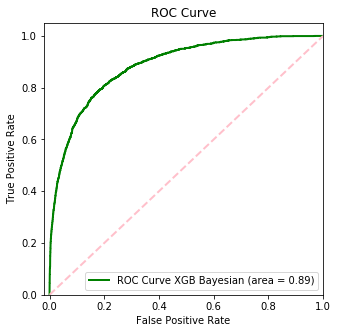

In [34]:
fpr, tpr, _ = roc_curve(y_train, y_pred_train)
roc_auc_xgb = auc(fpr, tpr)
print(roc_auc_xgb)
## COURBE
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='Green',
        lw=2, label='ROC Curve XGB Bayesian (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [35]:
feature_xgb_bayes = pd.DataFrame(sorted(zip(xgbModel.feature_importances_,
                                            X_test_encoded.columns)), 
                            columns=['Importance','Feature'])

feature_xgb_bayes

,Importance,Feature
0,0.006377,SEX
1,0.006977,YOJ
2,0.007294,CAR_AGE
3,0.008214,CLM_FREQ
4,0.010248,RED_CAR
5,0.014022,BLUEBOOK
6,0.016197,INCOME
7,0.017395,TRAVTIME
8,0.020615,AGE
9,0.021318,HOMEKIDS


### Export results

In [36]:
train_results = pd.DataFrame({'INDEX': data_train.INDEX, 'predict_proba': y_pred_train})
test_results = pd.DataFrame({'INDEX': data_test.INDEX, 'predict_proba': y_pred_test})

#### Chosing threshold so that the output has a correct negative/positive ratio

In [37]:
y_train.mean()

0.2638157088592084

In [38]:
y_train.value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

In [39]:
# Here, approximately, 26.5% of the target variable observations are positive
# Choose the threshold based on the train data set so that 26.5% on train set is 1, then use this for test set

In [40]:
sorted_predict_proba = train_results.predict_proba.sort_values(ignore_index=True)
threshold = sorted_predict_proba[round(len(y_train)*(1-y_train.mean()))]

In [41]:
train_results['predict'] = (train_results.predict_proba >= threshold).astype(int)
test_results['predict'] = (test_results.predict_proba >= threshold).astype(int)

In [42]:
train_results.predict.value_counts()

0    6008
1    2153
Name: predict, dtype: int64

In [43]:
test_results

,INDEX,predict_proba,predict
0,3,0.129406,0
1,9,0.332646,0
2,10,0.066619,0
3,18,0.107523,0
4,21,0.079625,0
...,...,...,...
2136,10279,0.409516,1
2137,10281,0.036795,0
2138,10285,0.013538,0
2139,10294,0.236491,0


In [44]:
test_results[["INDEX", "predict"]].to_csv(RESULT_PATH + "pred_test.csv", sep = ",", index=False)